Necessary Imports

In [2]:
import os
import glob
import random
import shutil
import cv2 as cv
import matplotlib.pyplot as plt


Visualizing images:


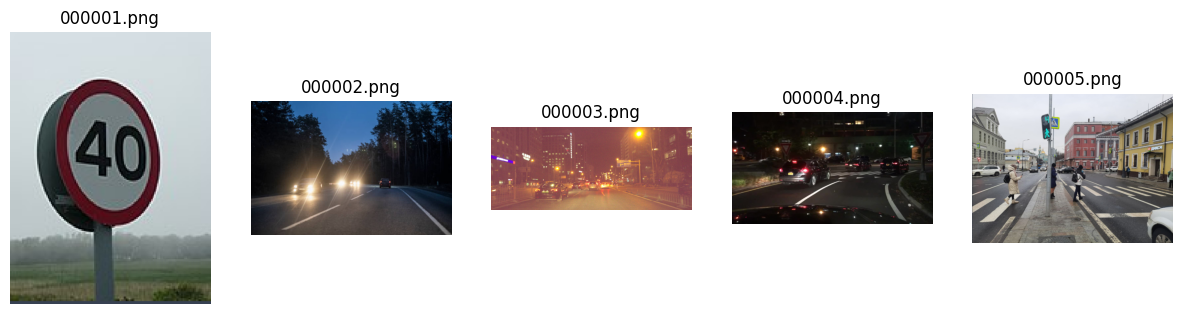

In [8]:
# Visualize images to assess data quality
def visualize_images(image_paths, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = cv.imread(str(img_path))
        if img is None:
            print(f"Image {img_path} is not readable.")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path))
        plt.axis('off')
    plt.show()

print("Visualizing images:")
image_paths = glob.glob(os.path.join("./Dataset", "*.png"))[:5]
visualize_images(image_paths)

Visualizing class distribution: 


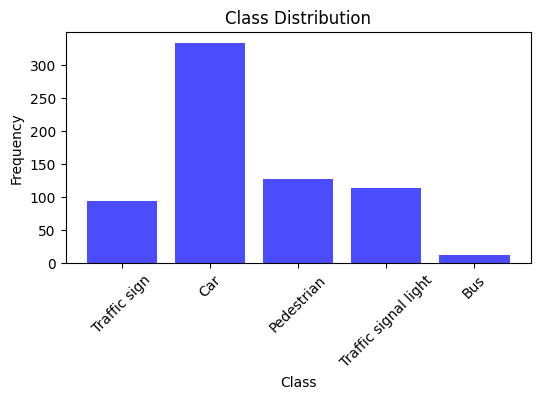

In [6]:
# get the labels from the YOLO annotation file
def get_yolo_labels(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    labels = [int(line.strip().split()[0]) for line in lines]  # class_id
    return labels

# Count the number of instances per class
def count_classes_from_labels(label_paths):
    class_counts = {}
    for label_file in label_paths:
        labels = get_yolo_labels(label_file)
        for label in labels:
            class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

# Visualize the class distribution
def visualize_class_distribution(class_counts, class_names):
    class_labels = [class_names[class_id] for class_id in class_counts.keys()]
    counts = list(class_counts.values())

    plt.figure(figsize=(6, 3))
    plt.bar(class_labels, counts, color='blue', alpha=0.7)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

label_paths = glob.glob(os.path.join("./Dataset", "*.txt")) 
class_counts = count_classes_from_labels(label_paths)
class_names = ["Traffic sign", "Car", "Pedestrian", "Traffic signal light", "Bus"]
print("Visualizing class distribution: ")
visualize_class_distribution(class_counts, class_names)


Splitting Dataset

In [10]:
def split_dataset(image_dir, annotation_dir, train_ratio=0.8):
    images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    
    train_images = images[:train_size]
    val_images = images[train_size:]
    
    for img in train_images:
        # path = os.path.join('train', 'images', img)
        # print(path)
        shutil.copy(os.path.join(image_dir, img), os.path.join('train', 'images', img))
        shutil.copy(os.path.join(annotation_dir, img.replace('.png', '.txt')), os.path.join('train', 'labels', img.replace('.png', '.txt')))
        
    for img in val_images:
        shutil.copy(os.path.join(image_dir, img), os.path.join('val', 'images', img))
        shutil.copy(os.path.join(annotation_dir, img.replace('.png', '.txt')), os.path.join('val', 'labels', img.replace('.png', '.txt')))

split_dataset('./Dataset/', './Dataset/')


Model Training

In [3]:
import torch
from ultralytics import YOLO
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
#GPU checking
torch.cuda.is_available()

True

In [5]:
# Load a model
model = YOLO("yolo11n.pt")
model.train(data="data.yaml", 
            epochs = 100, 
            batch=16,
            imgsz=640,
            patience=0, #Stop early stopping
            mixup=0.1, # augmentation factor
            device = 0,  )

New https://pypi.org/project/ultralytics/8.3.71 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.27  Python-3.8.17 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=100, time=None, patience=0, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning D:\4.2Thesis\SRBD\Vehicle Detection\train\labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\4.2Thesis\SRBD\Vehicle Detection\val\labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.51G      1.437      3.873      1.163         78        640: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         30        130      0.124      0.202     0.0658     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.4G      1.297      3.481      1.082         80        640: 100%|██████████| 8/8 [00:01<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         30        130     0.0737      0.412      0.149      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.43G      1.344       2.93      1.092         53        640: 100%|██████████| 8/8 [00:01<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         30        130     0.0457      0.523      0.218       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.51G      1.378      2.503      1.118         62        640: 100%|██████████| 8/8 [00:01<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         30        130     0.0296      0.535      0.255      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.45G      1.388      2.029        1.1         84        640: 100%|██████████| 8/8 [00:01<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         30        130     0.0195      0.514      0.254      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.45G      1.411      1.826      1.168         81        640: 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         30        130      0.976     0.0694      0.237      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.42G      1.388       1.67      1.152         42        640: 100%|██████████| 8/8 [00:01<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         30        130      0.963     0.0548      0.271      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.43G      1.324      1.497      1.101         77        640: 100%|██████████| 8/8 [00:01<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         30        130      0.978       0.05      0.324      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.47G      1.339      1.512       1.13         79        640: 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         30        130      0.969     0.0886      0.346      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.43G      1.364      1.442      1.142         92        640: 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         30        130      0.953      0.118      0.335      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.43G      1.303      1.383      1.098         73        640: 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         30        130      0.922      0.152      0.322      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.42G      1.316       1.41      1.143         87        640: 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         30        130       0.89      0.168      0.343      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.45G      1.317      1.403      1.122         65        640: 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         30        130      0.734      0.255      0.354       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.45G      1.262       1.32      1.093         93        640: 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         30        130      0.679       0.28      0.322       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.48G      1.263      1.362      1.117         75        640: 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         30        130      0.601      0.273       0.34      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.43G      1.292      1.333      1.121         88        640: 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         30        130      0.587      0.282       0.39      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.42G      1.277       1.28      1.091         92        640: 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         30        130      0.589      0.426      0.451      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.38G      1.247      1.252      1.102         82        640: 100%|██████████| 8/8 [00:01<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         30        130      0.571      0.512      0.524      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.45G      1.226      1.241      1.088         93        640: 100%|██████████| 8/8 [00:01<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         30        130      0.742      0.486       0.49        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.52G      1.222      1.206      1.081         76        640: 100%|██████████| 8/8 [00:00<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         30        130       0.68      0.518      0.491      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.43G      1.208      1.131      1.062         77        640: 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         30        130      0.706      0.503      0.481      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.45G      1.241      1.184      1.088         84        640: 100%|██████████| 8/8 [00:01<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all         30        130      0.682      0.501      0.467      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.51G      1.205      1.174      1.081         77        640: 100%|██████████| 8/8 [00:01<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         30        130      0.722      0.503      0.536      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.48G      1.254      1.164      1.072         99        640: 100%|██████████| 8/8 [00:01<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         30        130      0.612      0.571      0.542      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.48G      1.179      1.112      1.063         77        640: 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         30        130      0.707      0.477      0.549      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.42G      1.133      1.107      1.033         75        640: 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         30        130      0.678      0.586      0.556      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.42G      1.137      1.103      1.054         73        640: 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         30        130      0.684      0.563      0.578      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.44G       1.16      1.114       1.07         71        640: 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

                   all         30        130      0.785      0.519      0.543      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.44G      1.126       1.07       1.06         68        640: 100%|██████████| 8/8 [00:01<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         30        130      0.758      0.527      0.543      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.41G      1.095     0.9836      1.025         75        640: 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         30        130       0.69      0.559      0.583      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.42G      1.102      1.016      1.013         55        640: 100%|██████████| 8/8 [00:01<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         30        130      0.819      0.526      0.594      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.42G      1.134      1.047       1.04         72        640: 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         30        130      0.698      0.581      0.587       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.48G      1.119      1.016      1.032         73        640: 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         30        130      0.632      0.585      0.582      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.43G      1.121      1.047      1.049         63        640: 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         30        130      0.816      0.502      0.579      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.45G      1.112     0.9937      1.028         56        640: 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         30        130      0.627      0.595      0.573      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.52G      1.144      1.026      1.024         96        640: 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         30        130      0.858      0.496      0.586      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.46G      1.074     0.9569      1.002         61        640: 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         30        130      0.796      0.464      0.574      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.43G      1.112     0.9797      1.033         62        640: 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         30        130      0.813      0.471      0.592      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.46G        1.1      1.035      1.027         88        640: 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all         30        130      0.813      0.473      0.534      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.42G      1.108      1.015      1.028         45        640: 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         30        130      0.752      0.499       0.56      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.43G      1.061     0.9275      1.016         94        640: 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         30        130      0.776      0.477      0.514      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.47G      1.029     0.9039     0.9832         70        640: 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         30        130      0.802      0.476      0.514      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.48G      1.059     0.9127      1.005         84        640: 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


                   all         30        130      0.806      0.504      0.532      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.44G      1.075     0.9438      1.023         87        640: 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         30        130      0.746      0.527      0.519      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.5G      1.084     0.9649      1.016        108        640: 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         30        130      0.768      0.477      0.506      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.43G      1.032     0.9238     0.9886         87        640: 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         30        130      0.779      0.496      0.534      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.62G      1.054      0.927          1         75        640: 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         30        130      0.845      0.498      0.586      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.42G      1.043     0.9047      1.004         63        640: 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         30        130      0.831      0.538      0.605      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.46G      1.032     0.9048     0.9869         72        640: 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         30        130      0.839        0.5      0.597       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G      1.056     0.9295      1.007        104        640: 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         30        130      0.754      0.546      0.617      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.42G      1.003     0.8699     0.9764         72        640: 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


                   all         30        130      0.812      0.555      0.635      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G     0.9797     0.8672     0.9751         82        640: 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         30        130      0.753       0.54      0.626      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.43G     0.9938     0.8861     0.9716         96        640: 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         30        130      0.713       0.56      0.605      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.41G     0.9587     0.8352     0.9569         70        640: 100%|██████████| 8/8 [00:01<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         30        130      0.728      0.569       0.61      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.42G      1.003     0.8729     0.9732         71        640: 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         30        130      0.741      0.593       0.64      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.47G     0.9483     0.7913     0.9641         76        640: 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         30        130      0.803      0.559      0.627      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.42G     0.9729     0.8312     0.9745         68        640: 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         30        130      0.769      0.565      0.647      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.45G      1.019     0.8714     0.9856         99        640: 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         30        130      0.773       0.64      0.673      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.43G     0.9749     0.8588     0.9641        100        640: 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         30        130      0.686       0.63      0.665      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.54G       0.99     0.8443     0.9778         77        640: 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         30        130      0.594      0.683      0.643       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.44G     0.9896     0.8496      0.967         69        640: 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         30        130      0.614       0.63      0.656      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.42G     0.9612     0.8293     0.9629        105        640: 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         30        130      0.768       0.57      0.628      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.47G     0.9389     0.8197     0.9604         98        640: 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         30        130      0.764      0.553      0.638      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.45G     0.8994     0.7856      0.958         65        640: 100%|██████████| 8/8 [00:01<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         30        130      0.754      0.585      0.633      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.47G     0.9109     0.7844     0.9422         84        640: 100%|██████████| 8/8 [00:01<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         30        130      0.591      0.628      0.621      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.42G     0.8946     0.7506     0.9308         50        640: 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         30        130      0.824       0.54      0.623      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.41G     0.9278     0.7927     0.9487         83        640: 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         30        130      0.766      0.577       0.62      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.46G     0.9388     0.7989     0.9529        105        640: 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         30        130      0.791      0.545       0.59      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.41G     0.9056     0.7718     0.9399         72        640: 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         30        130      0.631      0.634      0.621      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.42G     0.9209       0.77     0.9375         85        640: 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         30        130      0.806      0.596      0.643      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.41G     0.8614     0.7393     0.9275         55        640: 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         30        130      0.842      0.587      0.628      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.43G     0.9656     0.8137      0.964        116        640: 100%|██████████| 8/8 [00:01<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         30        130      0.806      0.591      0.631      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.38G     0.9118     0.7776      0.948         98        640: 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         30        130      0.669      0.631      0.633      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.44G     0.9043     0.7812     0.9444         71        640: 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         30        130      0.626      0.675      0.649      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.45G     0.8947     0.7461      0.952         62        640: 100%|██████████| 8/8 [00:01<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


                   all         30        130      0.668      0.652      0.654      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.45G     0.8641     0.7315     0.9252         99        640: 100%|██████████| 8/8 [00:01<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         30        130      0.752      0.601      0.655        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.42G     0.8966     0.7405     0.9303         60        640: 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         30        130       0.74      0.604      0.651      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.51G     0.9128     0.7587     0.9471         77        640: 100%|██████████| 8/8 [00:01<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         30        130      0.695      0.621      0.645      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.48G     0.8802     0.7282     0.9274         78        640: 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         30        130      0.609      0.643      0.642      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.42G     0.8841     0.7855     0.9364        141        640: 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         30        130      0.855      0.535      0.638      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.43G     0.8443     0.7157     0.9192         65        640: 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         30        130      0.837      0.549      0.639      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.47G     0.8449     0.7139     0.9196         68        640: 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         30        130      0.644      0.642      0.649       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.42G     0.8395     0.6997     0.9227         61        640: 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         30        130      0.596      0.648      0.644      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.44G     0.8274      0.702     0.9315         40        640: 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         30        130      0.537      0.656      0.641      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.44G     0.8252     0.6892      0.925         86        640: 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         30        130      0.595      0.639      0.637      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.5G     0.8065     0.7088     0.9286         75        640: 100%|██████████| 8/8 [00:01<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all         30        130      0.573      0.636      0.612      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.43G     0.8485     0.7202     0.9331        115        640: 100%|██████████| 8/8 [00:01<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         30        130      0.572      0.624      0.605      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.44G     0.8712     0.7538     0.9438         43        640: 100%|██████████| 8/8 [00:01<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         30        130      0.635       0.61      0.615      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.43G     0.8287     0.7066      0.924        100        640: 100%|██████████| 8/8 [00:01<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         30        130      0.673      0.603      0.625      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.44G     0.8014     0.6933     0.9117         53        640: 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         30        130      0.614      0.612      0.622      0.393


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.5G     0.7875     0.8146     0.8961         44        640: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         30        130      0.651        0.6       0.64      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.38G     0.8424     0.8252      0.909         34        640: 100%|██████████| 8/8 [00:01<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         30        130      0.803      0.547      0.639      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.38G     0.7891     0.7329     0.8772         36        640: 100%|██████████| 8/8 [00:01<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         30        130      0.825      0.532      0.628      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.38G     0.7899      0.772      0.887         34        640: 100%|██████████| 8/8 [00:01<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         30        130      0.836      0.515      0.626      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.41G      0.766     0.7458     0.8832         31        640: 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         30        130      0.786      0.551      0.622      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.41G     0.7526     0.7182     0.8866         42        640: 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         30        130      0.715      0.584      0.618      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.4G     0.7519     0.7054     0.8729         39        640: 100%|██████████| 8/8 [00:01<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         30        130      0.533      0.628       0.62      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.4G     0.7703     0.7183     0.8836         30        640: 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         30        130      0.795      0.526      0.586      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.38G     0.7446     0.6936     0.8848         34        640: 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         30        130      0.526      0.643      0.603      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.4G     0.7447       0.69     0.8752         44        640: 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         30        130      0.643       0.64      0.625      0.401



100 epochs completed in 0.049 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.27  Python-3.8.17 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         30        130      0.773       0.64      0.672      0.445
          Traffic sign         14         22      0.723      0.545      0.618      0.378
                   Car         26         64       0.71      0.891      0.877      0.621
            Pedestrian          6         17      0.647      0.765      0.678      0.407
  Traffic signal light         13         23      0.786      0.522      0.584      0.298
                   Bus          3          4          1      0.477      0.602      0.521
Speed: 0.4ms preprocess, 1.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E25FA80940>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

Validate data with Trained model

In [6]:
model = YOLO("./runs/detect/train2/weights/best.pt")

# Run inference on the validation images and save the output images to a specific folder
results = model.predict(source='./val/images', save=True)



image 1/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000004.png: 384x640 3 Cars, 69.8ms
image 2/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000007.png: 224x640 2 Cars, 52.8ms
image 3/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000010.png: 224x640 4 Cars, 2 Pedestrians, 15.6ms
image 4/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000013.png: 512x640 1 Car, 45.1ms
image 5/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000022.png: 640x480 (no detections), 50.0ms
image 6/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000026.png: 224x640 4 Cars, 8.1ms
image 7/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000057.png: 224x640 2 Traffic signs, 4 Cars, 1 Traffic signal light, 9.9ms
image 8/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000146.png: 224x640 1 Traffic sign, 5 Cars, 14.8ms
image 9/30 d:\4.2Thesis\SRBD\Vehicle Detection\val\images\000167.png: 224x640 1 Traffic sign, 4 Cars, 1 Traffic signal light, 9.0ms
image 10/30 d:\4.2Thesis\SRBD\Vehicle Detecti